In [2]:
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.0345, 0.8419, 0.8869],
        [0.0206, 0.6084, 0.5557],
        [0.9111, 0.4046, 0.5511],
        [0.9436, 0.6862, 0.2714],
        [0.4721, 0.4940, 0.2738]])


In [3]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als, bias, basic, user_knn, svd, tf, item_knn as knn
from lenskit.algorithms import bias
from lenskit import topn
import seaborn as sns
import lenskit
from lenskit.metrics.predict import rmse
import lift
import scipy.sparse as sps
from csr import CSR
from sklearn.model_selection import train_test_split


In [3]:
cocktails = pd.read_csv("cocktails.csv")
cocktails

,name,category,measurement-1,ingredient-1,measurement-2,ingredient-2,measurement-3,ingredient-3,measurement-4,ingredient-4,measurement-5,ingredient-5,measurement-6,ingredient-6,instructions,glass,glass-size
0,Gauguin,Cocktail Classics,2 oz,Light Rum,1 oz,Passion Fruit Syrup,1 oz,Lemon Juice,1 oz,Lime Juice,NaN,NaN,NaN,NaN,Combine ingredients with a cup of crushed ice ...,Old-Fashioned Glass,6 to 8 ounces
1,Fort Lauderdale,Cocktail Classics,1 1/2 oz,Light Rum,1/2 oz,Sweet Vermouth,1/4 oz,Juice of Orange,1/4 oz,Juice of a Lime,NaN,NaN,NaN,NaN,Shake with ice and strain into old-fashioned g...,Old-Fashioned Glass,6 to 8 ounces
2,Apple Pie,Cordials and Liqueurs,3 oz,Apple schnapps,1 oz,Cinnamon schnapps,NaN,Apple slice,NaN,NaN,NaN,NaN,NaN,NaN,Pour into ice-filled old-fashioned glass. Garn...,Old-Fashioned Glass,6 to 8 ounces
3,Cuban Cocktail No. 1,Cocktail Classics,1/2 oz,Juice of a Lime,1/2 oz,Powdered Sugar,2 oz,Light Rum,NaN,NaN,NaN,NaN,NaN,NaN,Shake with ice and strain into cocktail glass.,Cocktail Glass,6 or more ounces
4,Cool Carlos,Cocktail Classics,1 1/2 oz,Dark rum,2 oz,Cranberry Juice,2 oz,Pineapple Juice,1 oz,Orange curacao,1 oz,Sour Mix,NaN,NaN,"Mix all ingredients except curacao with ice, s...",Collins Glass,14 to 16 ounces
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,Wallis Blue Cocktail,Gin,1,"Lime wedge, superfine sugar",1 oz,Gin,1 oz,Triple Sec,1 oz,Fresh Lime Juice,NaN,NaN,NaN,NaN,Rim old-fashioned glass with lime and sugar. F...,Old-Fashioned Glass,6 to 8 ounces
986,Minnehaha Cocktail,Cocktail Classics,1/4 oz,Juice of Orange,1/2 oz,Dry Vermouth,1/2 oz,Sweet Vermouth,1 oz,Old Mr. Boston Dry Gin,NaN,NaN,NaN,NaN,Shake well with cracked ice and strain into 4 ...,Cocktail Glass,6 or more ounces
987,Wallick Cocktail,Gin,1 1/2 oz,Gin,1 1/2 oz,Dry Vermouth,1 oz,Triple Sec,NaN,NaN,NaN,NaN,NaN,NaN,Stir with ice and strain into chilled cocktail...,Cocktail Glass,6 or more ounces
988,Waikiki Beachcomber,Gin,3/4 oz,Gin,3/4 oz,Triple Sec,1/2 oz,Pineapple Juice,NaN,NaN,NaN,NaN,NaN,NaN,Shake with ice and strain into chilled cocktai...,Cocktail Glass,6 or more ounces


In [5]:
len(cocktails['category'].unique())

11

In [6]:
len(cocktails['ingredient-1'].unique())

238

In [7]:
len(cocktails['ingredient-2'].unique())

257

In [8]:
len(cocktails['ingredient-3'].unique())

228

In [9]:
len(cocktails['ingredient-4'].unique())

174

In [10]:
len(cocktails['ingredient-5'].unique())

145

In [11]:
len(cocktails['ingredient-6'].unique())

118

In [12]:
len(cocktails['ingredient-6'].dropna())

159

In [ ]:
np.unique(cocktails[['ingredient-1', 'ingredient-2', 'ingredient-3', 'ingredient-4', 'ingredient-5', 'ingredient-6']].values.astype(str))

In [61]:
len(np.unique(cocktails[['ingredient-1', 'ingredient-2', 'ingredient-3', 'ingredient-4', 'ingredient-5', 'ingredient-6']].values.astype(str)))

688

In [62]:
recipes = pd.read_csv('food.com-recipes-and-interactions/PP_recipes.csv')
recipes

,id,i,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids
0,424415,23,"[40480, 37229, 2911, 1019, 249, 6878, 6878, 28...","[[2911, 1019, 249, 6878], [1353], [6953], [153...","[40480, 40482, 21662, 481, 6878, 500, 246, 161...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[389, 7655, 6270, 1527, 3406]"
1,146223,96900,"[40480, 18376, 7056, 246, 1531, 2032, 40481]","[[17918], [25916], [2507, 6444], [8467, 1179],...","[40480, 40482, 729, 2525, 10906, 485, 43, 8393...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[2683, 4969, 800, 5298, 840, 2499, 6632, 7022,..."
2,312329,120056,"[40480, 21044, 16954, 8294, 556, 10837, 40481]","[[5867, 24176], [1353], [6953], [1301, 11332],...","[40480, 40482, 8240, 481, 24176, 296, 1353, 66...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1,"[1257, 7655, 6270, 590, 5024, 1119, 4883, 6696..."
3,74301,168258,"[40480, 10025, 31156, 40481]","[[1270, 1645, 28447], [21601], [27952, 29471, ...","[40480, 40482, 5539, 21601, 1073, 903, 2324, 4...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[7940, 3609, 7060, 6265, 1170, 6654, 5003, 3561]"
4,76272,109030,"[40480, 17841, 252, 782, 2373, 1641, 2373, 252...","[[1430, 11434], [1430, 17027], [1615, 23, 695,...","[40480, 40482, 14046, 1430, 11434, 488, 17027,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[3484, 6324, 7594, 243]"
...,...,...,...,...,...,...,...,...
178260,323143,76862,"[40480, 6444, 1964, 9369, 486, 569, 17551, 40481]","[[8780], [11835, 1762, 4465, 31494], [6812], [...","[40480, 40482, 729, 2525, 715, 485, 26641, 404...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,"[840, 208, 2499, 2683, 1925, 335, 1511]"
178261,149114,145962,"[40480, 17027, 24715, 974, 11877, 40481]","[[6812], [5940], [30645, 4785, 6821], [6953], ...","[40480, 40482, 729, 2525, 10906, 485, 43, 8393...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[2499, 4717, 1168, 6270, 6324, 7040]"
178262,34200,65066,"[40480, 12187, 11434, 1738, 2627, 40481]","[[6167, 20930, 510], [1353], [15022, 6953], [6...","[40480, 40482, 500, 246, 1719, 5024, 240, 2366...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",2,"[2378, 7655, 3219, 2320, 5168, 5319, 4189, 268..."
178263,30618,77358,"[40480, 870, 488, 1325, 519, 2220, 2417, 488, ...","[[12395, 38308, 40118], [3137, 15022], [30878,...","[40480, 40482, 562, 481, 10734, 240, 23667, 58...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[5627, 2807, 5412, 3399, 7979, 1093, 1257, 780..."


In [63]:
pd.read_csv('food.com-recipes-and-interactions/RAW_interactions.csv')

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."
...,...,...,...,...,...
1132362,116593,72730,2003-12-09,0,Another approach is to start making sauce with...
1132363,583662,386618,2009-09-29,5,These were so delicious! My husband and I tru...
1132364,157126,78003,2008-06-23,5,WOW! Sometimes I don't take the time to rate ...
1132365,53932,78003,2009-01-11,4,Very good! I used regular port as well. The ...


In [8]:
unsort_recipes = pd.read_csv('food.com-recipes-and-interactions/RAW_recipes.csv',converters={'ingredients': eval})
unsort_recipes

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"[winter squash, mexican seasoning, mixed spice...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"[prepared pizza crust, sausage patty, eggs, mi...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"[ground beef, yellow onions, diced tomatoes, t...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","[spreadable cheese with garlic and herbs, new ...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"[tomato juice, apple cider vinegar, sugar, sal...",8
...,...,...,...,...,...,...,...,...,...,...,...,...
231632,zydeco soup,486161,60,227978,2012-08-29,"['ham', '60-minutes-or-less', 'time-to-make', ...","[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,"[celery, onion, green sweet pepper, garlic clo...",22
231633,zydeco spice mix,493372,5,1500678,2013-01-09,"['15-minutes-or-less', 'time-to-make', 'course...","[14.8, 0.0, 2.0, 58.0, 1.0, 0.0, 1.0]",1,['mix all ingredients together thoroughly'],this spice mix will make your taste buds dance!,"[paprika, salt, garlic powder, onion powder, d...",13
231634,zydeco ya ya deviled eggs,308080,40,37779,2008-06-07,"['60-minutes-or-less', 'time-to-make', 'course...","[59.2, 6.0, 2.0, 3.0, 6.0, 5.0, 0.0]",7,"['in a bowl , combine the mashed yolks and may...","deviled eggs, cajun-style","[hard-cooked eggs, mayonnaise, dijon mustard, ...",8
231635,cookies by design cookies on a stick,298512,29,506822,2008-04-15,"['30-minutes-or-less', 'time-to-make', 'course...","[188.0, 11.0, 57.0, 11.0, 7.0, 21.0, 9.0]",9,['place melted butter in a large mixing bowl a...,"i've heard of the 'cookies by design' company,...","[butter, eagle brand condensed milk, light bro...",10


In [85]:
drink_index= []
index_count = 0
for tag in unsort_recipes['description'].values.astype('str'):
#     print(tag)
    if 'drink' in tag:
        drink_index.append(index_count)
    index_count = index_count + 1
#     for parse_tag in tag:
#         if 'cocktail' in parse_tag:
#             print(tag)
#         if parse_tag.contains('drink'):
#             print(tag)

In [87]:
len(drink_index)

3528

In [89]:
unsort_recipes.iloc[317]['tags']

"['time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'occasion', 'north-american', 'beverages', 'fruit', 'american', 'southern-united-states', '1-day-or-more', 'easy', 'dinner-party', 'fall', 'holiday-event', 'cocktails', 'dietary', 'seasonal', 'apples', '3-steps-or-less']"

In [94]:
beverage_index = []
index_count = 0
for tag in unsort_recipes['tags'].values:
#     print(tag)
    if 'beverages' in tag:
        beverage_index.append(index_count)
    index_count = index_count + 1

In [95]:
len(beverage_index)

11124

In [9]:
cocktails_index = []
index_count = 0
for tag in unsort_recipes['tags'].values:
#     print(tag)
    if 'cocktails' in tag:
        cocktails_index.append(index_count)
    index_count = index_count + 1

In [21]:
len(cocktails_index)

4313

In [10]:
cocktails = unsort_recipes.iloc[cocktails_index]
cocktails.info()
cocktails.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4313 entries, 102 to 230834
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   name            4313 non-null   object
 1   id              4313 non-null   int64 
 2   minutes         4313 non-null   int64 
 3   contributor_id  4313 non-null   int64 
 4   submitted       4313 non-null   object
 5   tags            4313 non-null   object
 6   nutrition       4313 non-null   object
 7   n_steps         4313 non-null   int64 
 8   steps           4313 non-null   object
 9   description     4263 non-null   object
 10  ingredients     4313 non-null   object
 11  n_ingredients   4313 non-null   int64 
dtypes: int64(5), object(7)
memory usage: 438.0+ KB


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
102,truth serum margaritas,45859,30,59756,2002-11-13,"['30-minutes-or-less', 'time-to-make', 'course...","[72.0, 0.0, 61.0, 0.0, 0.0, 0.0, 6.0]",3,"['mix limeade , lime juice , tequila and tripl...",you'll know why i call it truth serum after yo...,"[limeade, lime juice, tequila, triple sec, lim...",6
264,red robin drink recipe mai tai,175306,1,329471,2006-06-28,"['15-minutes-or-less', 'time-to-make', 'course...","[160.9, 0.0, 46.0, 0.0, 0.0, 0.0, 5.0]",6,['add grenadine and orgeat into a bottom of gl...,tropical mai tai from \r\nred robin gourmet bu...,"[grenadine, orgeat syrup, white rum, orange cu...",9
272,sexy greek cocktail,423875,5,65502,2010-05-07,"['15-minutes-or-less', 'time-to-make', 'course...","[94.7, 0.0, 70.0, 0.0, 2.0, 0.0, 7.0]",2,['just mix together ouzo and orange juice and ...,the greek lady that made this recipe said that...,"[ouzo, orange juice, ice cube, orange slice]",4
295,white sangria,251021,5,383346,2007-09-04,"['15-minutes-or-less', 'time-to-make', 'course...","[158.0, 0.0, 6.0, 0.0, 0.0, 0.0, 1.0]",3,"['pour wine , vodka , schnapps and peach couli...","another sangria, but from the calabash bar in ...","[dry white wine, lemon-flavored vodka, peach s...",11
304,007 martini,429524,5,599450,2010-06-12,"['celebrity', '15-minutes-or-less', 'time-to-m...","[146.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",4,['rinse martini glass with extra dry vermouth'...,based on a recipe from ray foley's the ultimat...,"[dry vermouth, vodka, gin, lillet blanc]",4


In [171]:
ingredients = pd.DataFrame()
for cocktail_id in cocktails.id.values:
    for ingredient_list in cocktails.loc[cocktails['id'] == cocktail_id]['ingredients']:
        for ingredient in ingredient_list:
            ingredients = ingredients.append(pd.DataFrame([[cocktail_id,ingredient]], columns={'item', 'ingredient'}),ignore_index=True) 
#         print(ingredients)
ingredients

,item,ingredient
0,45859,limeade
1,45859,lime juice
2,45859,tequila
3,45859,triple sec
4,45859,lime wedge
...,...,...
21957,14224,stolichnaya vodka
21958,14224,ouzo
21959,238533,creme de cacao
21960,238533,almond liqueur


In [11]:
cocktails.to_csv('data/cocktails.csv')

In [196]:
drink_steps = pd.DataFrame()
for cocktail_id in cocktails.id.values:
    for ingredient_list in cocktails.loc[cocktails['id'] == cocktail_id]['n_steps']:
        for ingredient in ingredient_list:
        drink_steps = drink_steps.append(pd.DataFrame([[cocktail_id,ingredient]], columns={'item', 'n_steps'}),ignore_index=True) 
#         print(ingredients)
drink_steps

TypeError: 'int' object is not iterable

In [12]:
drink_steps = cocktails[['id', 'n_steps']] 
drink_steps = drink_steps.rename(columns={'id':'item'})
drink_steps

,item,n_steps
102,45859,3
264,175306,6
272,423875,2
295,251021,3
304,429524,4
...,...,...
230382,423088,2
230766,428485,3
230828,213532,2
230833,14224,2


In [13]:
drink_steps.to_csv('data/drink_steps.csv')

In [175]:
ingredients.to_csv('data/ingredients.csv')

In [173]:
len(ingredients['ingredient'].unique())

1619

In [106]:
ratings = pd.read_csv('food.com-recipes-and-interactions/RAW_interactions.csv')
ratings.info()
ratings.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132367 entries, 0 to 1132366
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   user_id    1132367 non-null  int64 
 1   recipe_id  1132367 non-null  int64 
 2   date       1132367 non-null  object
 3   rating     1132367 non-null  int64 
 4   review     1132198 non-null  object
dtypes: int64(3), object(2)
memory usage: 43.2+ MB


,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [113]:
filtered_ratings = ratings[ratings['recipe_id'].isin(cocktails['id'].values)]

In [178]:
filtered_ratings = filtered_ratings.drop(columns={'review'})

In [180]:
filtered_ratings = filtered_ratings.rename(columns={'user_id': 'user', 'recipe_id': 'item'})

In [184]:
filtered_ratings.reset_index(inplace=True)

In [187]:
filtered_ratings = filtered_ratings.drop(columns={'index'})

In [188]:
filtered_ratings.info()
filtered_ratings.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14297 entries, 0 to 14296
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   user    14297 non-null  int64 
 1   item    14297 non-null  int64 
 2   date    14297 non-null  object
 3   rating  14297 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 446.9+ KB


,user,item,date,rating
0,296027,182985,2007-05-19,4
1,452940,367080,2009-07-10,4
2,162826,367080,2009-10-04,5
3,303545,259553,2009-11-01,5
4,538524,280085,2008-04-12,5


In [4]:
# filtered_ratings.to_csv('data/filtered_ratings.csv')

NameError: name 'filtered_ratings' is not defined

In [190]:
len(filtered_ratings['user'].unique())

3613

In [31]:
from sklearn.model_selection import train_test_split
train ,test = train_test_split(filtered_ratings,test_size=0.2, random_state=456)  

In [56]:
from sklearn.model_selection import train_test_split
train ,test = train_test_split(ratings_above_5,test_size=0.2, random_state=456)  

In [113]:
train ,test = train_test_split(ratings_items_above_5,test_size=0.2, random_state=456)  

In [109]:
train ,test = train_test_split(maybe_test,test_size=0.2, random_state=456)  

In [118]:
from hydrink import DrinkTagMF


In [103]:
popular = basic.Popular()
ImplicitMF = als.ImplicitMF(50)
SVD = svd.BiasedSVD(25)
biases = bias.Bias()
itemItem = knn.ItemItem(20,2)
itemItemSum = knn.ItemItem(20,2,aggregate='sum')


BPR = tf.BPR(50)
liftmod = lift.Lift()

from hydrink import DrinkTagMF
customBPR = DrinkTagMF(n_features=500, reg=0.001, device='cuda')

users = test.user.unique()
items = test.item.unique()

fittable = util.clone(popular)
fittable = Recommender.adapt(fittable)
print(f"start training popular_model")
fittable.fit(train)
print(f"done training popular_model")
print(f"start pickle popular_model")
filename = f'popular_model.sav'
pickle.dump(model, open(filename, 'wb'))
print(f"done with pickle popular_model")
print(f"start recommend popular_model")
recs = batch.recommend(fittable, users, 50)
print(f"done with recommend popular_model")
recs['Algorithm'] = f'popular'
print(f"save recommend popular_model to file")
recs.to_csv('all_recs4.csv')


fittable = util.clone(SVD)
fittable = Recommender.adapt(fittable)
print(f"start training SVD_model")
fittable.fit(train)
print(f"done training SVD_model")
print(f"start pickle SVD_model")
filename = f'SVD_model.sav'
pickle.dump(model, open(filename, 'wb'))
print(f"done with pickle SVD_model")
print(f"start recommend SVD_model")
recs = batch.recommend(fittable, users, 50)
print(f"done with recommend ISVD_model")
recs['Algorithm'] = f'SVD'
print(f"save recommend SVD_model to file")
recs.to_csv('all_recs4.csv', mode='a', header=False)


fittable = util.clone(ImplicitMF)
fittable = Recommender.adapt(fittable)
print(f"start training ImplicitMF_model")
fittable.fit(train)
print(f"done training ImplicitMF_model")
print(f"start pickle ImplicitMF_model")
filename = f'ImplicitMF_model.sav'
pickle.dump(model, open(filename, 'wb'))
print(f"done with pickle ImplicitMF_model")
print(f"start recommend ImplicitMF_model")
recs = batch.recommend(fittable, users, 50)
print(f"done with recommend ImplicitMF_model")
recs['Algorithm'] = f'ImplicitMF'
print(f"save recommend ImplicitMF_model to file")
recs.to_csv('all_recs4.csv', mode='a', header=False)


fittable = util.clone(ExplicitMF)
fittable = Recommender.adapt(fittable)
print(f"start training ExplicitMF_model")
fittable.fit(train)
print(f"done training ExplicitMF_model")
print(f"start pickle ExplicitMF_model")
filename = f'ExplicitMF_model.sav'
pickle.dump(model, open(filename, 'wb'))
print(f"done with pickle ExplicitMF_model")
print(f"start recommend ExplicitMF_model")
recs = batch.recommend(fittable, users, 50)
print(f"done with recommend ExplicitMF_model")
recs['Algorithm'] = f'ExplicitMF'
print(f"save recommend ExplicitMF_model to file")
recs.to_csv('all_recs4.csv', mode='a', header=False)


fittable = util.clone(itemItemSum)
fittable = Recommender.adapt(fittable)
print(f"start training itemItemSum_model")
fittable.fit(train)
print(f"done training itemItemSum_model")
print(f"start pickle itemItemSum_model")
filename = f'itemItemSum_model.sav'
pickle.dump(model, open(filename, 'wb'))
print(f"done with pickle itemItemSum_model")
print(f"start recommend itemItemSum_model")
recs = batch.recommend(fittable, users, 50)
print(f"done with recommend itemItemSum_model")
recs['Algorithm'] = f'itemItemSum'
print(f"save recommend itemItemSum_model to file")
recs.to_csv('all_recs4.csv', mode='a', header=False)



fittable = util.clone(itemItem)
fittable = Recommender.adapt(fittable)
print(f"start training itemItem_model")
fittable.fit(train)
print(f"done training itemItem_model")
print(f"start pickle itemItem_model")
filename = f'itemItem_model.sav'
pickle.dump(model, open(filename, 'wb'))
print(f"done with pickle itemItem_model")
print(f"start recommend itemItem_model")
recs = batch.recommend(fittable, users, 50)
print(f"done with recommend itemItem_model")
recs['Algorithm'] = f'itemItem'
print(f"save recommend itemItem_model to file")
recs.to_csv('all_recs4.csv', mode='a', header=False)



fittable = util.clone(biases)
fittable = Recommender.adapt(fittable)
print(f"start training biases_model")
fittable.fit(train)
print(f"done training biases_model")
print(f"start pickle biases_model")
filename = f'biases_model.sav'
pickle.dump(model, open(filename, 'wb'))
print(f"done with pickle biases_model")
print(f"start recommend biases_model")
recs = batch.recommend(fittable, users, 50)
print(f"done with recommend biases_model")
recs['Algorithm'] = f'biases'
print(f"save recommend biases_model to file")
recs.to_csv('all_recs4.csv', mode='a', header=False)


fittable = util.clone(customBPR)
fittable = Recommender.adapt(fittable)
print(f"start training customBPR_model")
fittable.fit(train, ingredients=ingredients, ingredientCounts=drink_steps)
print(f"done training customBPR_model")
print(f"start pickle customBPR_model")
filename = f'customBPR_model.sav'
pickle.dump(model, open(filename, 'wb'))
print(f"done with pickle customBPR_model")
print(f"start recommend customBPR_model")
recs = batch.recommend(fittable, users, 50)
print(f"done with recommend customBPR_model")
recs['Algorithm'] = f'customBPR'
print(f"save recommend customBPR_model to file")
recs.to_csv('all_recs4.csv', mode='a', header=False)



start training popular_model
done training popular_model
start pickle popular_model
done with pickle popular_model
start recommend popular_model
done with recommend popular_model
save recommend popular_model to file
start training SVD_model
done training SVD_model
start pickle SVD_model
done with pickle SVD_model
start recommend SVD_model
done with recommend ISVD_model
save recommend SVD_model to file
start training ImplicitMF_model
done training ImplicitMF_model
start pickle ImplicitMF_model
done with pickle ImplicitMF_model
start recommend ImplicitMF_model
done with recommend ImplicitMF_model
save recommend ImplicitMF_model to file
start training ExplicitMF_model
done training ExplicitMF_model
start pickle ExplicitMF_model
done with pickle ExplicitMF_model
start recommend ExplicitMF_model
done with recommend ExplicitMF_model
save recommend ExplicitMF_model to file
start training itemItemSum_model
done training itemItemSum_model
start pickle itemItemSum_model
done with pickle itemItem

AssertionError: 

In [123]:
filtered_ratings = pd.read_csv('data/filtered_ratings.csv', index_col = 0 )
ingredients = pd.read_csv('data/ingredients.csv', index_col = 0 )

In [6]:
filtered_ratings = filtered_ratings.drop(columns={"date"})
filtered_ratings

,user,item,rating
0,296027,182985,4
1,452940,367080,4
2,162826,367080,5
3,303545,259553,5
4,538524,280085,5
...,...,...,...
14292,32907,94338,4
14293,465056,255933,5
14294,37449,255933,5
14295,128473,255933,5


In [60]:
test

,user,item,date,rating
2619,169969,306714,2008-06-09,5
1651,227978,213034,2009-08-29,5
4330,61569,213182,2008-06-26,5
4470,330545,279301,2008-01-22,2
1886,679953,336382,2011-03-31,5
...,...,...,...,...
1523,280271,347635,2010-03-09,5
2259,1072593,270387,2012-01-21,5
2639,314579,166673,2006-06-14,5
2690,464080,229351,2009-05-18,5


In [101]:
train ,test = train_test_split(ratings_items_above_5,test_size=0.2, random_state=456)  
test2 = pd.DataFrame()
for user in train.user.unique():
    temp = test[test['user'] == user]
    if (len(temp) >= 1):
        test2 = test2.append(temp, ignore_index=True)
test2

,user,item,date,rating
0,382071,258558,2007-10-29,5
1,382071,303968,2008-06-06,4
2,382071,232298,2007-10-08,5
3,382071,240135,2007-10-06,4
4,382071,250764,2007-10-14,4
...,...,...,...,...
945,64203,66947,2008-05-26,5
946,282678,315657,2008-08-14,5
947,4470,8877,2005-12-08,5
948,4470,191999,2006-10-26,5


In [78]:
train ,test = train_test_split(ratings_items_above_5,test_size=0.2, random_state=456)  

popular = basic.Popular()
ImplicitMF = als.ImplicitMF(50)
BPR = tf.BPR(50)
liftmod = lift.Lift()

biases = bias.Bias()
userUser = user_knn.UserUser(30)
itemItem = knn.ItemItem(20,2)
itemItemSum = knn.ItemItem(20,2,aggregate='sum')
ExplicitMF = als.BiasedMF(50)
SVD = svd.BiasedSVD(25)

from hydrink import DrinkTagMF
model = DrinkTagMF(50, device='cuda')

users = test.user.unique()
items = test.item.unique()

fittable = util.clone(model)
fittable = Recommender.adapt(fittable)
print(f"start training customBPR_model")
fittable.fit(train, ingredients=ingredients, ingredientCounts=drink_steps)
print(f"done training customBPR_model")
print(f"start pickle customBPR_model")
filename = f'customBPR_model.sav'
pickle.dump(model, open(filename, 'wb'))
print(f"done with pickle customBPR_model")
print(f"start recommend customBPR_model")
recs = batch.recommend(fittable, users, 50)
print(f"done with recommend customBPR_model")
recs['Algorithm'] = f'customBPR'
print(f"save recommend customBPR_model to file")
# recs.to_csv('all_recs.csv', mode='a', header=False)
recs.to_csv('all_recs5.csv')

start training customBPR_model



done training customBPR_model
start pickle customBPR_model
done with pickle customBPR_model
start recommend customBPR_model


user 50969 unknown
user 33159 unknown
user 114027 unknown
user 1800054678 unknown
user 303700 unknown
user 280166 unknown
user 68460 unknown
user 461428 unknown


done with recommend customBPR_model
save recommend customBPR_model to file


In [86]:
counter = 1
for i in [5,10,25,50,75,100,200]:
    for j in [0.1,0.01,0.001]:
        model = DrinkTagMF(n_features=i, reg=j, device='cuda')
        fittable = util.clone(model)
        fittable = Recommender.adapt(fittable)
        print(f"start training hydrink_model{counter}")
        fittable.fit(train, ingredients=ingredients, ingredientCounts=drink_steps)
        print(f"done training hydrink_model{counter}")
        print(f"start pickle hydrink_model{counter}")
        filename = f'hydrink_model{counter}.sav'
        pickle.dump(model, open(filename, 'wb'))
        print(f"done with pickle hydrink_model{counter}")
        print(f"start recommend hydrink_model{counter}")
        recs = batch.recommend(fittable, users, 50)
        print(f"done with recommend hydrink_model{counter}")
        recs['Algorithm'] = f'hydrink_{counter}'
        print(f"save recommend hydrink_model{counter} to file")
        recs.to_csv('all_recs5.csv', mode='a', header=False)
        counter = counter + 1

TypeError: __init__() got an unexpected keyword argument 'n_features'

<AxesSubplot:xlabel='Algorithm'>

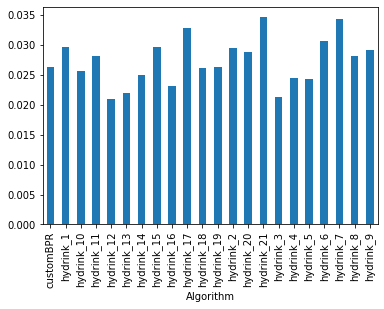

In [81]:
from lenskit import topn
import pandas as pd
# test6 = pd.read_csv('test6.csv', index_col = 0 )
test_data = pd.DataFrame()
test_data = []
test_data.append(test)
test_data = pd.concat(test_data, ignore_index=True)
test_rec = pd.read_csv('all_recs5.csv', index_col = 0 )
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg)
results = rla.compute(test_rec, test_data)

results.head()
results.groupby('Algorithm').ndcg.mean()
results.groupby('Algorithm').ndcg.mean().plot.bar()

In [84]:
counter = 1
for i in [225,250,275,300,500]:
    for j in [0.1,0.01,0.001]:
        model = DrinkTagMF(n_features=i, reg=j, device='cuda')
        fittable = util.clone(model)
        fittable = Recommender.adapt(fittable)
        print(f"start training hydrink_model{counter}")
        fittable.fit(train, ingredients=ingredients, ingredientCounts=drink_steps)
        print(f"done training hydrink_model{counter}")
        print(f"start pickle hydrink_model{counter}")
        filename = f'hydrink_model{counter}.sav'
        pickle.dump(model, open(filename, 'wb'))
        print(f"done with pickle hydrink_model{counter}")
        print(f"start recommend hydrink_model{counter}")
        recs = batch.recommend(fittable, users, 50)
        print(f"done with recommend hydrink_model{counter}")
        recs['Algorithm'] = f'hydrink_{counter}'
        print(f"save recommend hydrink_model{counter} to file")
        if(counter == 1):
             recs.to_csv('all_recs6.csv')
        else:
            recs.to_csv('all_recs6.csv', mode='a', header=False)
        counter = counter + 1

start training hydrink_model1



done training hydrink_model1
start pickle hydrink_model1
done with pickle hydrink_model1
start recommend hydrink_model1


user 50969 unknown
user 33159 unknown
user 114027 unknown
user 1800054678 unknown
user 303700 unknown
user 280166 unknown
user 68460 unknown
user 461428 unknown


done with recommend hydrink_model1
save recommend hydrink_model1 to file
start training hydrink_model2



done training hydrink_model2
start pickle hydrink_model2
done with pickle hydrink_model2
start recommend hydrink_model2


user 50969 unknown
user 33159 unknown
user 114027 unknown
user 1800054678 unknown
user 303700 unknown
user 280166 unknown
user 68460 unknown
user 461428 unknown


done with recommend hydrink_model2
save recommend hydrink_model2 to file
start training hydrink_model3



done training hydrink_model3
start pickle hydrink_model3
done with pickle hydrink_model3
start recommend hydrink_model3


user 50969 unknown
user 33159 unknown
user 1800054678 unknown
user 114027 unknown
user 303700 unknown
user 280166 unknown
user 68460 unknown
user 461428 unknown


done with recommend hydrink_model3
save recommend hydrink_model3 to file
start training hydrink_model4



done training hydrink_model4
start pickle hydrink_model4
done with pickle hydrink_model4
start recommend hydrink_model4


user 50969 unknown
user 33159 unknown
user 114027 unknown
user 1800054678 unknown
user 303700 unknown
user 280166 unknown
user 68460 unknown
user 461428 unknown


done with recommend hydrink_model4
save recommend hydrink_model4 to file
start training hydrink_model5



done training hydrink_model5
start pickle hydrink_model5
done with pickle hydrink_model5
start recommend hydrink_model5


user 50969 unknown
user 33159 unknown
user 114027 unknown
user 1800054678 unknown
user 303700 unknown
user 280166 unknown
user 68460 unknown
user 461428 unknown


done with recommend hydrink_model5
save recommend hydrink_model5 to file
start training hydrink_model6



done training hydrink_model6
start pickle hydrink_model6
done with pickle hydrink_model6
start recommend hydrink_model6


user 50969 unknown
user 33159 unknown
user 1800054678 unknown
user 114027 unknown
user 303700 unknown
user 280166 unknown
user 68460 unknown
user 461428 unknown


done with recommend hydrink_model6
save recommend hydrink_model6 to file
start training hydrink_model7



done training hydrink_model7
start pickle hydrink_model7
done with pickle hydrink_model7
start recommend hydrink_model7


user 50969 unknown
user 33159 unknown
user 114027 unknown
user 1800054678 unknown
user 303700 unknown
user 280166 unknown
user 68460 unknown
user 461428 unknown


done with recommend hydrink_model7
save recommend hydrink_model7 to file
start training hydrink_model8



done training hydrink_model8
start pickle hydrink_model8
done with pickle hydrink_model8
start recommend hydrink_model8


user 50969 unknown
user 33159 unknown
user 114027 unknown
user 1800054678 unknown
user 303700 unknown
user 280166 unknown
user 68460 unknown
user 461428 unknown


done with recommend hydrink_model8
save recommend hydrink_model8 to file
start training hydrink_model9



done training hydrink_model9
start pickle hydrink_model9
done with pickle hydrink_model9
start recommend hydrink_model9


user 50969 unknown
user 33159 unknown
user 114027 unknown
user 1800054678 unknown
user 303700 unknown
user 280166 unknown
user 68460 unknown
user 461428 unknown


done with recommend hydrink_model9
save recommend hydrink_model9 to file
start training hydrink_model10



done training hydrink_model10
start pickle hydrink_model10
done with pickle hydrink_model10
start recommend hydrink_model10


user 50969 unknown
user 33159 unknown
user 114027 unknown
user 1800054678 unknown
user 303700 unknown
user 280166 unknown
user 68460 unknown
user 461428 unknown


done with recommend hydrink_model10
save recommend hydrink_model10 to file
start training hydrink_model11



done training hydrink_model11
start pickle hydrink_model11
done with pickle hydrink_model11
start recommend hydrink_model11


user 50969 unknown
user 33159 unknown
user 1800054678 unknown
user 114027 unknown
user 303700 unknown
user 280166 unknown
user 68460 unknown
user 461428 unknown


done with recommend hydrink_model11
save recommend hydrink_model11 to file
start training hydrink_model12



done training hydrink_model12
start pickle hydrink_model12
done with pickle hydrink_model12
start recommend hydrink_model12


user 50969 unknown
user 33159 unknown
user 1800054678 unknown
user 114027 unknown
user 303700 unknown
user 280166 unknown
user 68460 unknown
user 461428 unknown


done with recommend hydrink_model12
save recommend hydrink_model12 to file
start training hydrink_model13



done training hydrink_model13
start pickle hydrink_model13
done with pickle hydrink_model13
start recommend hydrink_model13


user 50969 unknown
user 33159 unknown
user 114027 unknown
user 1800054678 unknown
user 303700 unknown
user 280166 unknown
user 68460 unknown
user 461428 unknown


done with recommend hydrink_model13
save recommend hydrink_model13 to file
start training hydrink_model14



done training hydrink_model14
start pickle hydrink_model14
done with pickle hydrink_model14
start recommend hydrink_model14


user 50969 unknown
user 33159 unknown
user 114027 unknown
user 1800054678 unknown
user 303700 unknown
user 280166 unknown
user 68460 unknown
user 461428 unknown


done with recommend hydrink_model14
save recommend hydrink_model14 to file
start training hydrink_model15



done training hydrink_model15
start pickle hydrink_model15
done with pickle hydrink_model15
start recommend hydrink_model15


user 50969 unknown
user 33159 unknown
user 114027 unknown
user 1800054678 unknown
user 303700 unknown
user 280166 unknown
user 68460 unknown
user 461428 unknown


done with recommend hydrink_model15
save recommend hydrink_model15 to file


<AxesSubplot:xlabel='Algorithm'>

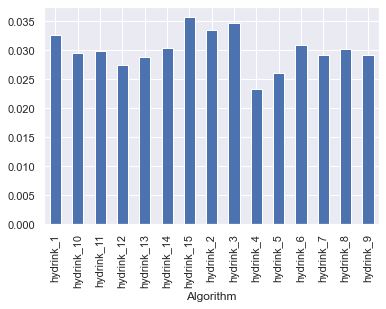

In [114]:
from lenskit import topn
import pandas as pd
# test6 = pd.read_csv('test6.csv', index_col = 0 )
test_data = pd.DataFrame()
test_data = []
test_data.append(test)
test_data = pd.concat(test_data, ignore_index=True)
test_rec = pd.read_csv('all_recs6.csv', index_col = 0 )
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg)
results = rla.compute(test_rec, test_data)

results.head()
results.groupby('Algorithm').ndcg.mean()
results.groupby('Algorithm').ndcg.mean().plot.bar()

<AxesSubplot:xlabel='Algorithm'>

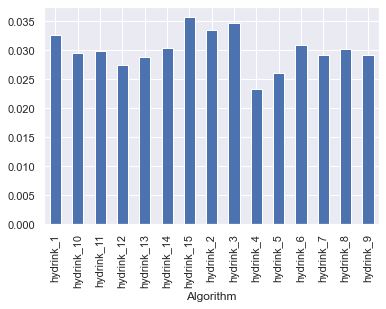

In [104]:
from lenskit import topn
import pandas as pd
# test6 = pd.read_csv('test6.csv', index_col = 0 )
test_data = pd.DataFrame()
test_data = []
test_data.append(test)
test_data = pd.concat(test_data, ignore_index=True)
test_rec = pd.read_csv('all_recs6.csv', index_col = 0 )
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg)
results = rla.compute(test_rec, test_data)

results.head()
results.groupby('Algorithm').ndcg.mean()
results.groupby('Algorithm').ndcg.mean().plot.bar()

In [119]:
users = test.user.unique()
items = test.item.unique()
# filename = f'hydrink_model21.sav'
# model = pickle.load(open(filename, 'rb'))
model = DrinkTagMF(n_features=200, reg=0.001, device='cuda')

fittable = util.clone(model)
fittable = Recommender.adapt(fittable)
#         print(f"start training hydrink_model{counter}")
fittable.fit(train, ingredients=ingredients, ingredientCounts=drink_steps)
#         print(f"done training hydrink_model{counter}")
#         print(f"start pickle hydrink_model{counter}")
# filename = f'hydrink_model25.sav'
#         pickle.dump(model, open(filename, 'wb'))
#         print(f"done with pickle hydrink_model{counter}")
#         print(f"start recommend hydrink_model{counter}")
recs = batch.recommend(fittable, users, 50)
#         print(f"done with recommend hydrink_model{counter}")
recs['Algorithm'] = f'customBPR_hyperparameterTuned'
#         print(f"save recommend hydrink_model{counter} to file")
recs.to_csv('all_recs2.csv', mode='a', header=False)

user 50969 unknown
user 33159 unknown
user 114027 unknown
user 1800054678 unknown
user 303700 unknown
user 280166 unknown
user 68460 unknown
user 461428 unknown


In [33]:
test_rec = pd.read_csv('all_recs.csv', index_col = 0 )
test_rec

,item,score,user,rank,Algorithm
0,66947,88.000000,125640,1,popular
1,18458,68.000000,125640,2,popular
2,234344,66.000000,125640,3,popular
3,88364,39.000000,125640,4,popular
4,59148,38.000000,125640,5,popular
...,...,...,...,...,...
29245,50797,0.108096,457690,46,customBPR
29246,487069,0.108066,457690,47,customBPR
29247,244731,0.108044,457690,48,customBPR
29248,248572,0.108034,457690,49,customBPR


In [40]:
# test_rec[:193084].to_csv('all_recs.csv')

In [34]:
test_rec[test_rec['Algorithm'] != 'customBPR']

,item,score,user,rank,Algorithm
0,274360,0.214185,141293,1,customBPR
1,254112,0.163628,141293,2,customBPR
2,210450,0.158582,141293,3,customBPR
3,172896,0.158262,141293,4,customBPR
4,290578,0.156002,141293,5,customBPR
...,...,...,...,...,...
29245,50797,0.108096,457690,46,customBPR
29246,487069,0.108066,457690,47,customBPR
29247,244731,0.108044,457690,48,customBPR
29248,248572,0.108034,457690,49,customBPR


In [53]:
from sklearn.model_selection import train_test_split
train ,test = train_test_split(filtered_ratings,test_size=0.2, random_state=456)  

<AxesSubplot:xlabel='Algorithm'>

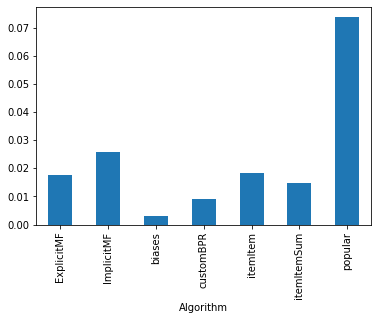

In [54]:
from lenskit import topn
import pandas as pd
# test6 = pd.read_csv('test6.csv', index_col = 0 )
test_data = pd.DataFrame()
test_data = []
test_data.append(test)
test_data = pd.concat(test_data, ignore_index=True)
test_rec = pd.read_csv('all_recs.csv', index_col = 0 )
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg)
results = rla.compute(test_rec, test_data)

results.head()
results.groupby('Algorithm').ndcg.mean()
results.groupby('Algorithm').ndcg.mean().plot.bar()

In [55]:
results

nrecs      ndcg
Algorithm  user                       
ExplicitMF 1535         50.0  0.000000
           1634         50.0  0.000000
           2178         50.0  0.000000
           2310         50.0  0.000000
           4439         50.0  0.000000
...                      ...       ...
popular    2002175450   50.0  0.000000
           2002223735   50.0  0.218104
           2002233010   50.0  0.000000
           2002238191   50.0  0.218104
           2002351275   50.0       NaN

[4524 rows x 2 columns]

<AxesSubplot:xlabel='Algorithm'>

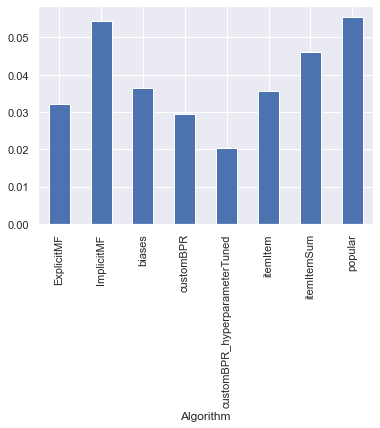

In [120]:
from lenskit import topn
import pandas as pd
# test6 = pd.read_csv('test6.csv', index_col = 0 )
test_data = pd.DataFrame()
test_data = []
test_data.append(test)
test_data = pd.concat(test_data, ignore_index=True)
test_rec = pd.read_csv('all_recs2.csv', index_col = 0 )
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg)
results = rla.compute(test_rec, test_data)
results.head()
results.groupby('Algorithm').ndcg.mean()
results.groupby('Algorithm').ndcg.mean().plot.bar()

<AxesSubplot:xlabel='Algorithm'>

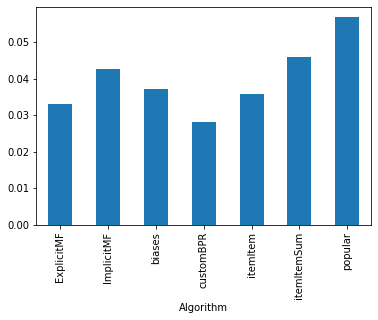

In [64]:
from lenskit import topn
import pandas as pd
# test6 = pd.read_csv('test6.csv', index_col = 0 )
test_data = pd.DataFrame()
test_data = []
test_data.append(test2)
test_data = pd.concat(test_data, ignore_index=True)
test_rec = pd.read_csv('all_recs3.csv', index_col = 0 )
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg)
results = rla.compute(test_rec, test_data)

results.head()
results.groupby('Algorithm').ndcg.mean()
results.groupby('Algorithm').ndcg.mean().plot.bar()

In [114]:
test.groupby(['user', 'item']).first()

date  rating       ingredient  n_steps
user       item                                                
1535       30392   2005-01-27       5           kahlua        2
           36536   2006-06-06       5       watermelon        4
           48814   2006-05-01       4       whole milk        3
           60354   2006-01-11       3      heavy cream        4
           72387   2006-03-11       5    strong coffee        3
...                       ...     ...              ...      ...
2002298826 294532  2018-10-12       4       cold water        6
2002319904 243479  2018-11-03       5            pisco        3
2002351275 312980  2018-11-29       0             milk        9
2002361607 107273  2018-12-09       5  vanilla extract       16
2002363832 234344  2018-12-12       0            water        6

[9206 rows x 4 columns]

In [112]:
test.drop_duplicates(subset=['user','item'], keep="last").reset_index(drop = True)

KeyError: Index(['user,item'], dtype='object')

In [102]:
from lenskit import topn
import pandas as pd
# test6 = pd.read_csv('test6.csv', index_col = 0 )
test_data = pd.DataFrame()
test_data = []
test_data.append(test.drop_duplicates())
test_data = pd.concat(test_data, ignore_index=True)
test_rec = pd.read_csv('all_recs4.csv', index_col = 0 )
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg)
results = rla.compute(test_rec, test_data)

results.head()
results.groupby('Algorithm').ndcg.mean()
results.groupby('Algorithm').ndcg.mean().plot.bar()

KeyError: (1634,)

In [10]:
user2 = []
for user in users:
    if user in train.user.unique():
        user2.append(user)

In [ ]:
# from sklearn.model_selection import train_test_split
# train ,test = train_test_split(filtered_ratings,test_size=0.2)  

popular = basic.Popular()
ImplicitMF = als.ImplicitMF(50)
BPR = tf.BPR(50)
liftmod = lift.Lift()

from hybook import BookTagMF
model = BookTagMF(50, device='gpu')

# users = test.user.unique()
items = test.item.unique()

fittable = util.clone(BPR)
fittable = Recommender.adapt(fittable)
print(f"start training BPR_model")
fittable.fit(train)
print(f"done training BPR_model")
print(f"start pickle BPR_model")
filename = f'BPR_model.sav'
pickle.dump(model, open(filename, 'wb'))
print(f"done with pickle BPR_model")
print(f"start recommend BPR_model")
recs = batch.recommend(fittable, users, 50)
print(f"done with recommend BPR_model")
recs['Algorithm'] = f'BPR'
print(f"save recommend BPR_model to file")
recs.to_csv('all_recs7.csv', mode='a', header=False)

In [14]:
fittable.fit(train)

In [16]:
batch.recommend(fittable, user2, 50)

KeyError: 28345

In [92]:
ratings_above_5 = pd.DataFrame()
for user in filtered_ratings.user.unique():
    temp = filtered_ratings[filtered_ratings['user'] == user]
    if (len(temp) >= 5):
        ratings_above_5 = ratings_above_5.append(temp, ignore_index=True)

In [93]:
ratings_above_5

,user,item,date,rating
0,296027,182985,2007-05-19,4
1,296027,277040,2008-01-23,5
2,296027,219209,2007-08-07,5
3,296027,249323,2007-09-11,4
4,296027,257713,2007-11-12,5
...,...,...,...,...
10165,416807,164049,2007-05-07,5
10166,416807,211811,2007-05-27,5
10167,416807,8821,2007-06-24,5
10168,416807,224747,2007-05-26,5


In [94]:
items_above_5 = pd.DataFrame()
for item in filtered_ratings.item.unique():
    temp = filtered_ratings[filtered_ratings['item'] == item]
    if (len(temp) >= 5):
        items_above_5 = items_above_5.append(temp, ignore_index=True)

In [95]:
items_above_5

,user,item,date,rating
0,1072593,202716,2009-12-02,5
1,201584,202716,2007-06-29,5
2,496803,202716,2009-01-09,5
3,383853,202716,2009-11-22,5
4,98467,202716,2010-04-27,5
...,...,...,...,...
8144,4470,163845,2007-12-16,5
8145,223169,163845,2007-12-22,5
8146,242729,163845,2007-12-23,5
8147,2150588,163845,2012-01-17,1


In [96]:
ratings_items_above_5 = pd.DataFrame()
for item in ratings_above_5.item.unique():
    temp = ratings_above_5[ratings_above_5['item'] == item]
    if (len(temp) >= 5):
        ratings_items_above_5 = ratings_items_above_5.append(temp, ignore_index=True)

In [97]:
ratings_items_above_5

,user,item,date,rating
0,296027,249323,2007-09-11,4
1,8688,249323,2007-11-27,5
2,382071,249323,2007-10-14,4
3,422893,249323,2007-09-07,4
4,43083,249323,2010-02-03,4
...,...,...,...,...
4799,35140,64184,2003-06-16,5
4800,156653,64184,2005-08-31,5
4801,189280,64184,2007-02-07,5
4802,38418,64184,2005-12-29,5


In [98]:
len(ratings_items_above_5.user.unique())

370

In [99]:
len(ratings_items_above_5.item.unique())

616

In [35]:
train ,test = train_test_split(filtered_ratings,test_size=0.2, random_state=546)  

In [43]:
test

,user,item,rating
2996,428885,255839,5
11930,383346,375019,5
11143,130663,318516,5
3736,470799,217467,5
166,130663,91061,5
...,...,...,...
8384,852269,319982,4
14049,114027,373221,5
4684,383346,298917,5
5467,37636,217397,5


In [42]:
test2 = pd.DataFrame()
for item in train.item.unique():
    test2 = test2.append(test[test['item'] == item], ignore_index=True)
test2

,user,item,rating
0,17803,244811,5
1,498271,279997,5
2,464926,279997,5
3,96092,279997,5
4,158087,62275,5
...,...,...,...
2387,1777192,323851,5
2388,2002121167,279095,0
2389,461834,279095,5
2390,498271,440382,5


In [45]:
test3 = pd.DataFrame()
for user in train.user.unique():
    test3 = test3.append(test[test['user'] == user], ignore_index=True)
test3

,user,item,rating
0,143318,264088,5
1,143318,429618,5
2,143318,217396,4
3,143318,309952,5
4,143318,251571,5
...,...,...,...
2279,2310,47526,4
2280,116856,183971,5
2281,559283,169601,3
2282,559283,163484,5


In [46]:
test4 = pd.DataFrame()
for user in train.user.unique():
    test4 = test4.append(test2[test2['user'] == user], ignore_index=True)
test4

,user,item,rating
0,143318,217396,4
1,143318,251571,5
2,143318,252237,5
3,143318,166675,5
4,143318,217536,5
...,...,...,...
1885,2310,36536,5
1886,2310,47526,4
1887,559283,169601,3
1888,559283,163484,5


In [ ]:
train = pd.DataFrame()
for item in items_above_5.item.unique():
    temp = items_above_5[items_above_5['item'] == item]
    
    if (len(temp) >= 5):
        items_above_5 = items_above_5.append(temp, ignore_index=True)

In [49]:
from sklearn.model_selection import train_test_split
# train ,test = train_test_split(items_above_5,test_size=0.2)  

popular = basic.Popular()
ImplicitMF = als.ImplicitMF(50)
BPR = tf.BPR(50)
liftmod = lift.Lift()

from hybook import BookTagMF
model = BookTagMF(50, device='gpu')

users = test2.user.unique()
items = test2.item.unique()

fittable = util.clone(liftmod)
fittable = Recommender.adapt(fittable)
print(f"start training lift_model")
fittable.fit(train)
print(f"done training lift_model")
print(f"start pickle lift_model")
filename = f'lift_model.sav'
pickle.dump(model, open(filename, 'wb'))
print(f"done with pickle lift_model")
print(f"start recommend lift_model")
recs = batch.recommend(fittable, users, 50)
print(f"done with recommend lift_model")
recs['Algorithm'] = f'lift'
print(f"save recommend lift_model to file")
recs.to_csv('all_recs.csv', mode='a', header=False)

start training lift_model



done training lift_model
start pickle lift_model
done with pickle lift_model
start recommend lift_model


KeyError: 464926

In [4]:
filtered_ratings = pd.read_csv('data/filtered_ratings.csv',index_col = 0)
filtered_ratings

,user,item,date,rating
0,296027,182985,2007-05-19,4
1,452940,367080,2009-07-10,4
2,162826,367080,2009-10-04,5
3,303545,259553,2009-11-01,5
4,538524,280085,2008-04-12,5
...,...,...,...,...
14292,32907,94338,2004-09-16,4
14293,465056,255933,2007-10-18,5
14294,37449,255933,2007-10-30,5
14295,128473,255933,2008-02-07,5


In [5]:
ingredients = pd.read_csv('data/ingredients.csv',index_col = 0)
ingredients
ingredients

,item,ingredient
0,45859,limeade
1,45859,lime juice
2,45859,tequila
3,45859,triple sec
4,45859,lime wedge
...,...,...
21957,14224,stolichnaya vodka
21958,14224,ouzo
21959,238533,creme de cacao
21960,238533,almond liqueur


In [98]:
drink_steps

,item,n_steps
102,45859,3
264,175306,6
272,423875,2
295,251021,3
304,429524,4
...,...,...
230382,423088,2
230766,428485,3
230828,213532,2
230833,14224,2


In [118]:
ingredients.set_index('item',inplace=True)

In [122]:
ingredients.T

item,45859,45859,45859,45859,45859,45859,175306,175306,175306,175306,...,213532,213532,213532,213532,213532,14224,14224,238533,238533,238533
ingredient,limeade,lime juice,tequila,triple sec,lime wedge,grand marnier,grenadine,orgeat syrup,white rum,orange curacao,...,grenadine,kahlua,midori melon liqueur,galliano,baileys irish cream,stolichnaya vodka,ouzo,creme de cacao,almond liqueur,irish cream


In [116]:
filtered_ratings.merge(ingredients, on='item')

,0,1,2,3,4,5,6,7,8,9,...,71541,71542,71543,71544,71545,71546,71547,71548,71549,71550
user,296027,296027,296027,296027,296027,296027,452940,452940,452940,452940,...,128473,128473,128473,128473,107583,107583,107583,107583,107583,107583
item,182985,182985,182985,182985,182985,182985,367080,367080,367080,367080,...,255933,255933,255933,255933,255933,255933,255933,255933,255933,255933
date,2007-05-19,2007-05-19,2007-05-19,2007-05-19,2007-05-19,2007-05-19,2009-07-10,2009-07-10,2009-07-10,2009-07-10,...,2008-02-07,2008-02-07,2008-02-07,2008-02-07,2008-05-04,2008-05-04,2008-05-04,2008-05-04,2008-05-04,2008-05-04
rating,4,4,4,4,4,4,4,4,4,4,...,5,5,5,5,5,5,5,5,5,5
ingredient,vodka,lime juice,triple sec,watermelon,ice cube,chambord raspberry liquor,brandy,apple juice,lemon juice,lemon slice,...,fresh lemon juice,fresh gingerroot,ginger ale,apple,apple juice,pear juice,fresh lemon juice,fresh gingerroot,ginger ale,apple


In [15]:
maybe_test = filtered_ratings.merge(ingredients, on='item').merge(drink_steps, on='item')

In [16]:
maybe_test.groupby(['user', 'item']).first()

date  rating                ingredient  n_steps
user       item                                                         
1535       8823    2005-06-15       5                     vodka        1
           15895   2006-02-25       5       baileys irish cream        2
           30392   2005-01-27       5                     vodka        2
           36536   2006-06-06       5                     sugar        4
           48814   2006-05-01       4                whole milk        3
...                       ...     ...                       ...      ...
2002345452 147772  2018-11-22       5  sweetened condensed milk        4
2002351275 312980  2018-11-29       0                  dark rum        9
2002352970 234344  2018-12-01       0                     water        6
2002361607 107273  2018-12-09       5                      eggs       16
2002363832 234344  2018-12-12       0                     water        6

[14297 rows x 4 columns]

In [126]:
train ,test = train_test_split(maybe_test,test_size=0.2, random_state=456)  


In [19]:
maybe_test

,user,item,date,rating,ingredient,n_steps
0,296027,182985,2007-05-19,4,vodka,4
1,296027,182985,2007-05-19,4,lime juice,4
2,296027,182985,2007-05-19,4,triple sec,4
3,296027,182985,2007-05-19,4,watermelon,4
4,296027,182985,2007-05-19,4,ice cube,4
...,...,...,...,...,...,...
71546,107583,255933,2008-05-04,5,pear juice,8
71547,107583,255933,2008-05-04,5,fresh lemon juice,8
71548,107583,255933,2008-05-04,5,fresh gingerroot,8
71549,107583,255933,2008-05-04,5,ginger ale,8


c:\users\jncwi\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


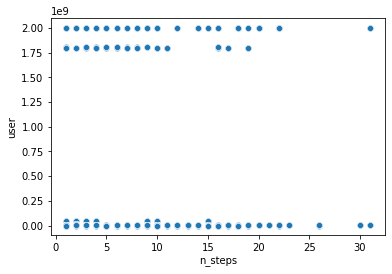

In [22]:
sns.scatterplot('n_steps', 'user', data=maybe_test.unique(subset=[['']]))
plt.show()

In [27]:
pd.read_csv('food.com-recipes-and-interactions/RAW_recipes.csv').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            231636 non-null  object
 1   id              231637 non-null  int64 
 2   minutes         231637 non-null  int64 
 3   contributor_id  231637 non-null  int64 
 4   submitted       231637 non-null  object
 5   tags            231637 non-null  object
 6   nutrition       231637 non-null  object
 7   n_steps         231637 non-null  int64 
 8   steps           231637 non-null  object
 9   description     226658 non-null  object
 10  ingredients     231637 non-null  object
 11  n_ingredients   231637 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 21.2+ MB


In [33]:
len(pd.read_csv('food.com-recipes-and-interactions/RAW_recipes.csv').name.unique())

230186

In [50]:
pd.read_csv('food.com-recipes-and-interactions/RAW_interactions.csv').info()

In [51]:
review = pd.read_csv('food.com-recipes-and-interactions/RAW_interactions.csv').review
review.dropna()     

0          Great with a salad. Cooked on top of stove for...
1          So simple, so delicious! Great for chilly fall...
2          This worked very well and is EASY.  I used not...
3          I made the Mexican topping and took it to bunk...
4          Made the cheddar bacon topping, adding a sprin...
                                 ...                        
1132362    Another approach is to start making sauce with...
1132363    These were so delicious!  My husband and I tru...
1132364    WOW!  Sometimes I don't take the time to rate ...
1132365    Very good!  I used regular port as well.  The ...
1132366    I am so glad I googled and found this here. Th...
Name: review, Length: 1132198, dtype: object

In [32]:
len(ingredients.ingredient.unique())

1619

In [47]:
len(maybe_test.ingredient.unique())

1619

In [45]:
cocktails.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4313 entries, 102 to 230834
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   name            4313 non-null   object
 1   id              4313 non-null   int64 
 2   minutes         4313 non-null   int64 
 3   contributor_id  4313 non-null   int64 
 4   submitted       4313 non-null   object
 5   tags            4313 non-null   object
 6   nutrition       4313 non-null   object
 7   n_steps         4313 non-null   int64 
 8   steps           4313 non-null   object
 9   description     4263 non-null   object
 10  ingredients     4313 non-null   object
 11  n_ingredients   4313 non-null   int64 
dtypes: int64(5), object(7)
memory usage: 438.0+ KB


In [40]:
len(cocktails.id.unique())

4313

In [43]:
len(maybe_test.item.unique())

4313

In [31]:
drink_steps

,item,n_steps
102,45859,3
264,175306,6
272,423875,2
295,251021,3
304,429524,4
...,...,...
230382,423088,2
230766,428485,3
230828,213532,2
230833,14224,2


In [35]:
len(filtered_ratings.user.unique())

3613

In [36]:
len(filtered_ratings.item.unique())

4313

In [48]:
filtered_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14297 entries, 0 to 14296
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   user    14297 non-null  int64 
 1   item    14297 non-null  int64 
 2   date    14297 non-null  object
 3   rating  14297 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 558.5+ KB


In [49]:
filtered_ratings.rating.mean()

4.589214520528782

In [90]:
for ing in maybe_test.ingredient.unique():
    print(ing)

vodka
lime juice
triple sec
watermelon
ice cube
chambord raspberry liquor
brandy
apple juice
lemon juice
lemon slice
sparkling wine
orange juice
orange sherbet
sugar
carbonated lemon-lime beverage
dry ice
grapes
citrus-infused vodka
apple schnapps
watermelon juice
ice
chocolate syrup
milk
peppermint schnapps
cool whip
hot chocolate powder
boiling water
frozen whipped topping
limeade
ice cubes
creme de cassis
champagne
lemon twists
tomato juice
white tequila
tabasco sauce
cilantro leaf
pineapple juice
rum
vanilla ice cream
creme de cacao
malibu rum
blue curacao
water
white sugar
brown sugar
almond extract
vanilla extract
black cherry gelatin
unflavored gelatin
coffee
maraschino cherries
whipped cream
apples
cinnamon stick
pure vanilla extract
spiced rum
peach schnapps
sour mix
cranberry juice
rose's lime juice
lime
cranberries
lime peel
pinot noir wine
nectarine
white rum
dark rum
coconut cream
double cream
angostura bitters
maraschino cherry
pineapple slice
blackberries
mushrooms
white

In [91]:
for ing in maybe_test.ingredient.unique():
    if ('vodka' in ing):
        print(ing)

vodka
citrus-infused vodka
vanilla vodka
raspberry vodka
mango vodka
absolut citron vodka
lemon-flavored vodka
apple vodka
absolut mandarin vodka
smirnoff citrus twist vodka
mandarin vodka
black vodka
green apple vodka
peach vodka
cranberry vodka
absolut vodka
stolichnaya raspberry vodka
ruby red grapefruit vodka
peppar vodka
stolichnaya vodka
cinnamon vodka
cherry vodka
orange-infused vodka
pear vodka
absolut kurant vodka
strawberry vodka
smirnoff no.21 vodka
100 proof vodka
blueberry vodka
coffee-infused vodka
espresso-flavored vodka
chocolate vodka
watermelon vodka
smirnoff orange vodka
mint vodka
stolichnaya ohranj vodka
lime-flavored vodka
pomegranate vodka
pineapple vodka
sweet tea flavored vodka


In [86]:
ingredients.groupby(['ingredient']).count()['item'].values

array([4, 4, 5, ..., 1, 1, 2], dtype=int64)

In [84]:
ingredients.groupby(['ingredient']).count().reset_index()

,ingredient,item
0,1% low-fat milk,4
1,100 proof vodka,4
2,2% low-fat milk,5
3,7-up,13
4,7-up soda,20
...,...,...
1614,yogurt,1
1615,your favorite liqueur,1
1616,yuzu,1
1617,yuzu juice,1


In [83]:
ingredients

,item,ingredient
0,45859,limeade
1,45859,lime juice
2,45859,tequila
3,45859,triple sec
4,45859,lime wedge
...,...,...
21957,14224,stolichnaya vodka
21958,14224,ouzo
21959,238533,creme de cacao
21960,238533,almond liqueur


c:\users\jncwi\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


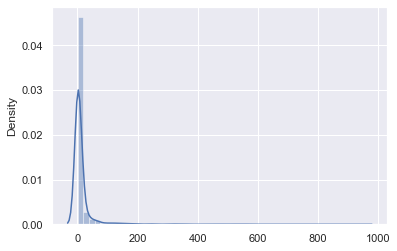

In [87]:
import seaborn as sns
sns.set_theme()
ax = sns.distplot(ingredients.groupby(['ingredient']).count()['item'].values)


c:\users\jncwi\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

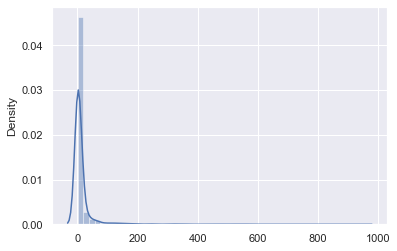

In [88]:
sns.distplot(ingredients.groupby(['ingredient']).count()['item'].values)